<h1>Import Nescessary Library</h1>

In [73]:
import pandas as pd
import numpy as np
import contractions
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.api.optimizers import Adam
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

<h1>Preprocess (Cleanse Data)</h1>

In [74]:
# Import Data
df = pd.read_csv("Dataset/Sentiment_Stock_data.csv", usecols=["Sentiment", "Sentence"])
# df = df.head(10000)
# print(df.to_string)


In [75]:
df = df.groupby("Sentiment").apply(lambda x: x.sample(n=10000, random_state=42))
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

C:\Users\User\AppData\Local\Temp\ipykernel_27308\3951322892.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Sentiment").apply(lambda x: x.sample(n=10000, random_state=42))


In [76]:
df.groupby(df["Sentiment"])["Sentiment"].count() 
df.to_string

<bound method DataFrame.to_string of        Sentiment                                           Sentence
0              1                          Merry Christmas, everyone
1              0  China's Railways Ministry - worlds 4th-largest...
2              0  Andy Coulson (former editor of the News of the...
3              0  Trial or nothing for Guantanamo Britons - Blun...
4              1  New Memo: Kissinger Gave the "Green Light" for...
...          ...                                                ...
19995          1  Putin says he envies Obama because he can spy ...
19996          1  Bomb found at planned Pope Francis visit site ...
19997          0  No news, and  No news is good news (except for...
19998          0                                The best of the 90s
19999          1  Putin was surprised at how easily Russia took ...

[20000 rows x 2 columns]>

In [77]:
def preprocess_text(text):
    # Check if text is a byte string, and decode if necessary
    if isinstance(text, bytes):
        text = text.decode('utf-8')  # Decode byte string to regular string

    # Expand contractions (e.g., "can't" -> "cannot")
    text = contractions.fix(text)

    # Convert to lowercase
    text = text.lower()

    text = re.sub('[^a-zA-Z]', ' ', text)

    # Return cleaned sentence
    return text

Deal With Null Data

In [78]:
# Drop Null value rows
df = df.dropna()

# Check Null
print(df.isnull().sum())
print(df.to_string)

Sentiment    0
Sentence     0
dtype: int64
<bound method DataFrame.to_string of        Sentiment                                           Sentence
0              1                          Merry Christmas, everyone
1              0  China's Railways Ministry - worlds 4th-largest...
2              0  Andy Coulson (former editor of the News of the...
3              0  Trial or nothing for Guantanamo Britons - Blun...
4              1  New Memo: Kissinger Gave the "Green Light" for...
...          ...                                                ...
19995          1  Putin says he envies Obama because he can spy ...
19996          1  Bomb found at planned Pope Francis visit site ...
19997          0  No news, and  No news is good news (except for...
19998          0                                The best of the 90s
19999          1  Putin was surprised at how easily Russia took ...

[20000 rows x 2 columns]>


Deal with Error Format Data

In [79]:
special_char= r'[a-zA-Z0-9]+(?:\s+[a-zA-Z0-9]+)*'

# Find rows where "Sentence" contains special characters
special_char_row = df[~df["Sentence"].str.contains(special_char, regex=True)].index
# print(len(special_char_row))

error_encode = "+ñ"
# Find rows where "Sentence" contains special characters
error_encode_row = df[df["Sentence"].str.contains(error_encode, regex=False)].index
# print(len(error_encode_row))

# Drop error encoded rows
# Drop special character rows
df.drop(special_char_row, axis=0, inplace=True)
df.drop(error_encode_row, axis=0, inplace=True)

df.to_string

<bound method DataFrame.to_string of        Sentiment                                           Sentence
0              1                          Merry Christmas, everyone
1              0  China's Railways Ministry - worlds 4th-largest...
2              0  Andy Coulson (former editor of the News of the...
3              0  Trial or nothing for Guantanamo Britons - Blun...
4              1  New Memo: Kissinger Gave the "Green Light" for...
...          ...                                                ...
19995          1  Putin says he envies Obama because he can spy ...
19996          1  Bomb found at planned Pope Francis visit site ...
19997          0  No news, and  No news is good news (except for...
19998          0                                The best of the 90s
19999          1  Putin was surprised at how easily Russia took ...

[19982 rows x 2 columns]>

In [80]:
df.reset_index(inplace=True)
df.drop(columns=["index"], inplace=True)
df["Sentence"] = df["Sentence"].apply(preprocess_text)


In [81]:
df.to_string

<bound method DataFrame.to_string of        Sentiment                                           Sentence
0              1                          merry christmas  everyone
1              0  china s railways ministry   worlds  th largest...
2              0  andy coulson  former editor of the news of the...
3              0  trial or nothing for guantanamo britons   blun...
4              1  new memo  kissinger gave the  green light  for...
...          ...                                                ...
19977          1  putin says he envies obama because he can spy ...
19978          1  bomb found at planned pope francis visit site ...
19979          0  no news  and  no news is good news  except for...
19980          0                                the best of the   s
19981          1  putin was surprised at how easily russia took ...

[19982 rows x 2 columns]>

<h1>Text Tokenization & Padding</h1>

In [82]:
# Hyper Parameter
vocab = 10000
embed_dim = 100
input_length = 100
optimizer = Adam(0.001)

In [83]:
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(df["Sentence"])

# Convert sentences to sequences of token ex. [340, 2, 14467, 1, 72, 15, 48, 220, 2, 352, 62, 702, 2, 73, 6316, 14, 9, 281, 1, 72, 9, 683]
tokenized = tokenizer.texts_to_sequences(df["Sentence"])

# Padding Sentence to same length
X = pad_sequences(tokenizer.texts_to_sequences(df["Sentence"]), maxlen=input_length, padding="pre")

# Change to numpy array for training
y = np.array(df["Sentiment"], dtype=np.int32)

In [84]:
# Load Pretrained GloVe Embeddings
glove_path = "glove.6B/glove.6B.100d.txt"
embedding_index = {}

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

# Create Embedding Matrix
embedding_matrix = np.zeros((vocab, embed_dim))
word_index = tokenizer.word_index

# Miss and Hit 
miss = 0
hit = 0
miss_vocab = []

for word, i in word_index.items():
    if i < vocab: # if index is outside vocab most frequency word
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
            hit += 1
        else:
            miss += 1
            miss_vocab.append(word)

print(f"Embedded Hit {hit} words\tMiss {miss} words")
print(miss_vocab)

Embedded Hit 9888 words	Miss 111 words
['stks', 'ruukki', 'isil', 'cargotec', 'mccarra', 'panostaja', 'outotec', 'salcomp', 'okmetic', 'aldata', 'cencorp', 'capman', 'ttip', 'incap', 'konecranes', 'scanfil', 'digia', 'teleste', 'vaahto', 'syrias', 'tsla', 'poyry', 'componenta', 'nsfw', 'raute', 'honkarakenne', 'basware', 'glaston', 'tiimari', 'tulikivi', 'tietoenator', 'ruokatalo', 'lemminkainen', 'aspocomp', 'affecto', 'olvi', 'egypts', 'aspo', 'tecnotree', 'baxalta', 'stonesoft', 'ukraines', 'nusra', 'redditors', 'tectia', 'caldern', 'talentum', 'nordstjernan', 'ramirent', 'erdoan', 'daesh', 'lastminute', 'bavelloni', 'paikallissanomat', 'crowdfund', 'pcln', 'hattenstone', 'solteq', 'xpost', 'trapwire', 'amzn', 'solidium', 'jurez', 'sysopen', 'breiviks', 'benefon', 'aktia', 'hkscan', 'greeces', 'guantnamo', 'worldnews', 'talvivaara', 'geosentric', 'cramo', 'lepard', 'protalix', 'biohit', 'endp', 'wukan', 'cybercom', 'sciard', 'neomarkka', 'ragutis', 'icelands', 'trendspotting', 'kaup

In [85]:
print(type(X), X.dtype, X.shape)
print(type(y), y.dtype, y.shape)

<class 'numpy.ndarray'> int32 (19982, 100)
<class 'numpy.ndarray'> int32 (19982,)


<h1> Spilt data </h1>

In [86]:
# Split the entire DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(df[df["Sentence"].str.match(X_train[1])])

In [87]:
print(type(X_train), X_train.dtype, X_train.shape)
print(type(y_train), y_train.dtype, y_train.shape)
print(type(X_test), X_test.dtype, X_test.shape)
print(type(y_test), y_test.dtype, y_test.shape)

<class 'numpy.ndarray'> int32 (15985, 100)
<class 'numpy.ndarray'> int32 (15985,)
<class 'numpy.ndarray'> int32 (3997, 100)
<class 'numpy.ndarray'> int32 (3997,)


<h1> Build Model </h1>

In [ ]:
model=Sequential()
model.add(Embedding(vocab, embed_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

c:\Users\User\OneDrive\Desktop\My Works\2567_2\AI\ai_venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

None


Training Model

In [89]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.4997 - loss: 0.6986 - val_accuracy: 0.4929 - val_loss: 0.6933
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 242s 970ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.4929 - val_loss: 0.6932
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 240s 958ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.4929 - val_loss: 0.6932
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.5057 - loss: 0.6931 - val_accuracy: 0.4929 - val_loss: 0.6932
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 890ms/step - accuracy: 0.4939 - loss: 0.6932 - val_accuracy: 0.4929 - val_loss: 0.6932
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 203s 812ms/step - accuracy: 0.4997 - loss: 0.6932 - val_accuracy: 0.4929 - val_loss: 0.6932
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 242s 969ms/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.4929 - val_loss: 0.6932
Epoch 8/20
214/250 ━━━━━━━━━━━━━━━━━━━━ 32s 892ms/step - accuracy: 0.5035 - loss: 

KeyboardInterrupt: 

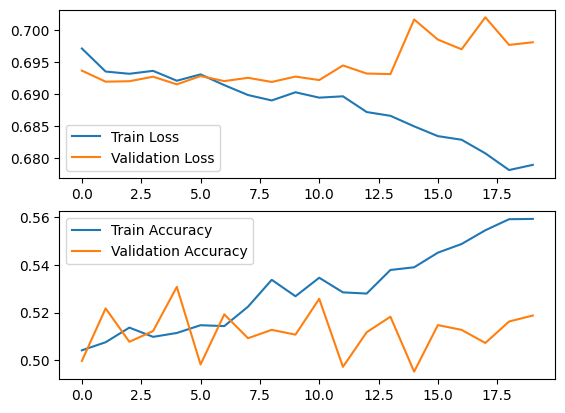

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

Evaluate Model

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5027 - loss: 0.7012
Test loss: 0.6981165409088135
Test accuracy: 0.5187593698501587


<h1> Plot Weights </h1>

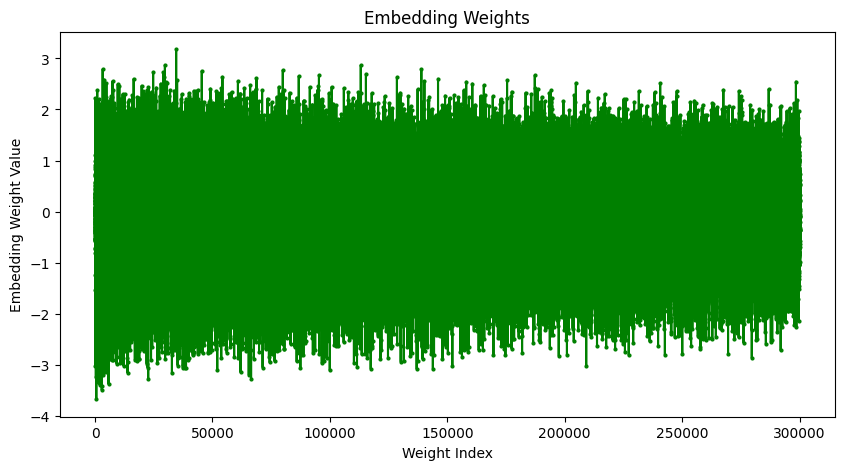

In [ ]:
embedding_weights = model.layers[0].get_weights()[0]  # Extracting embedding weights
embedding_weights_flat = embedding_weights.flatten()

# Create an index for the weights
embedding_index = np.arange(len(embedding_weights_flat))

# Plot the embedding weights
plt.figure(figsize=(10, 5))
plt.plot(embedding_index, embedding_weights_flat, marker='o', markersize=2, color='green')
plt.title('Embedding Weights')
plt.xlabel('Weight Index')
plt.ylabel('Embedding Weight Value')
plt.show()


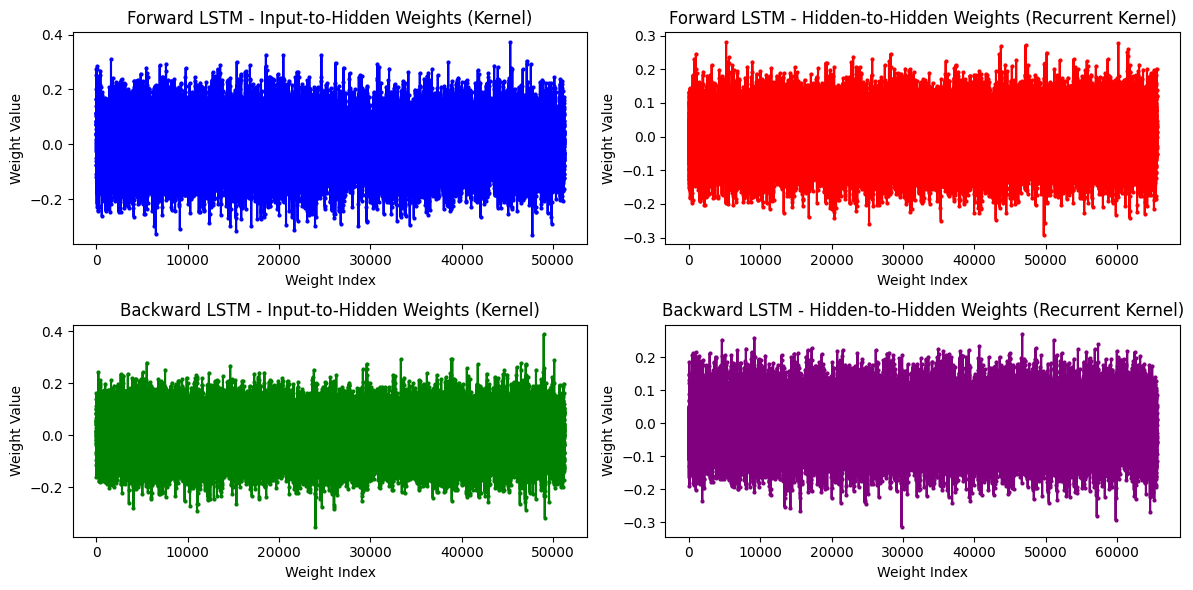

In [ ]:
# Extract the Bidirectional LSTM layer
bilstm_layer = model.layers[1]  # Bidirectional LSTM is at index 2

# Get forward and backward LSTM layers
forward_lstm = bilstm_layer.forward_layer
backward_lstm = bilstm_layer.backward_layer

# Extract weights
kernel_f, recurrent_kernel_f, bias_f = forward_lstm.get_weights()  # Forward LSTM
kernel_b, recurrent_kernel_b, bias_b = backward_lstm.get_weights()  # Backward LSTM

# Flatten weights
kernel_f_flat = kernel_f.flatten()
recurrent_f_flat = recurrent_kernel_f.flatten()
kernel_b_flat = kernel_b.flatten()
recurrent_b_flat = recurrent_kernel_b.flatten()  # Added missing recurrent weights for backward LSTM

# Create weight indices
kernel_f_index = np.arange(len(kernel_f_flat))
recurrent_f_index = np.arange(len(recurrent_f_flat))
kernel_b_index = np.arange(len(kernel_b_flat))
recurrent_b_index = np.arange(len(recurrent_b_flat))  # Fixed missing index

# Plot Forward LSTM weights
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(kernel_f_index, kernel_f_flat, marker='o', linestyle='-', markersize=2, color='blue')
plt.title('Forward LSTM - Input-to-Hidden Weights (Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2, 2, 2)
plt.plot(recurrent_f_index, recurrent_f_flat, marker='o', linestyle='-', markersize=2, color='red')
plt.title('Forward LSTM - Hidden-to-Hidden Weights (Recurrent Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

# Plot Backward LSTM weights
plt.subplot(2, 2, 3)
plt.plot(kernel_b_index, kernel_b_flat, marker='o', linestyle='-', markersize=2, color='green')
plt.title('Backward LSTM - Input-to-Hidden Weights (Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2, 2, 4)
plt.plot(recurrent_b_index, recurrent_b_flat, marker='o', linestyle='-', markersize=2, color='purple')  # Fixed missing plot
plt.title('Backward LSTM - Hidden-to-Hidden Weights (Recurrent Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.tight_layout()
plt.show()


<h1> Prediction </h1>

In [ ]:

text = ["Japan's Sony more than doubles net loss forecast to $6.4 billion"]
label = 0
tokenized_text = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=input_length, padding="pre")
predict = model.predict(tokenized_text)
print(predict)
print(f"Label is {label} Predict is 0") if predict < 0.5 else print(f"Label is {label} Predict is 1")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
[[0.0855571]]
Label is 0 Predict is 0


<h1> Save the model </h1>

model.save("mymodel.h5")
model.save_weights("mymodel.weights.h5")